1. Derive a variant of the algorithm above with memory complexity O(1) – informally, that 
the memory usage remains constant regardless of the number of misclassifications.

$\textbf{Data:} \mathcal{D} := \{(\mathbf{x_1},y_1),...,(\mathbf{x_n}, y_n)\}\\                     
\textbf{Result:} \mathcal{v} := \{\mathbf{w}\}\\            
\mathbf{w} := 0^d\\                          
\mathbf{s} := 0^d\\
\textbf{while} \quad \textit{not converged} \quad \textbf{do}\\                          
\qquad \textbf{for} \quad i := 1,...,n \quad \textbf{do}\\              
\qquad \hat{y} =
  \begin{cases}
    1  & \quad \mathbf{w} \cdot \mathbf{x_i} \geq 0\\
    0  & \quad \text{otherwise}
  \end{cases}\\               
\qquad \textbf{if} \quad \hat{y} \neq y \quad \textbf{then}\\                 
\qquad \quad \mathbf{w} = \mathbf{w} + (y - \hat{y})\mathbf{x_i}\\          
\qquad \textbf{end}\\                 
\qquad \mathbf{s} = \mathbf{s} + \mathbf{w}\\             
\quad \textbf{end}\\                   
\textbf{end}$                         

The trained algorithm performs predictions as follows:

$$f(\mathbf{x}) = 
    \begin{cases}
        1 \quad \mathbf{s} \cdot \mathbf{x} \geq 0\\
        0 \quad \text{otherwise}
    \end{cases}$$

2. Prove that your efficient variant is functionally equivalent to the algorithm above.

$$
    \displaystyle\sum^{k}_{i=1} c_i(\mathbf{w_i} \cdot \mathbf{x}) =
    \displaystyle\sum^{k}_{i=1} c_i \displaystyle\sum^{d}_{j=1} (\mathbf{w_i})_j x_j = \\
    = \displaystyle\sum^{k}_{i=1} \displaystyle\sum^{d}_{j=1} c_i (\mathbf{w_i})_j x_j = 
    \displaystyle\sum^{d}_{j=1} \displaystyle\sum^{k}_{i=1} c_i (\mathbf{w_i})_j x_j = \\
    = \displaystyle\sum^{d}_{j=1} x_j \bigg(\displaystyle\sum^{k}_{i=1} c_i (\mathbf{w_i})_j \bigg) = 
    \displaystyle\sum^{d}_{j=1} x_j \bigg(\displaystyle\sum^{k}_{i=1} c_i \mathbf{w_i} \bigg)_j = \\
    = \mathbf{x} \cdot \mathbf{s} \\
$$

3. Implement your efficient variant.

In [1]:
import tarfile
import urllib.request
import numpy as np
from matplotlib import pyplot as plt
plt.set_cmap("gray") # Otherwise grayscale images look purple
%matplotlib inline

In [2]:
url = 'http://udon.stacken.kth.se/~ninjin/comp0090_assignment_1_data.tar.gz'
ftpstream = urllib.request.urlopen(url)
tar = tarfile.open(fileobj=ftpstream, mode="r|gz")
tar.extractall()
tar.close

<bound method TarFile.close of <tarfile.TarFile object at 0x119872588>>

In [3]:
trainxs = np.load("comp0090_assignment_1_data/fashion-train-imgs.npz").transpose((2, 1, 0))
trainys = np.load("comp0090_assignment_1_data/fashion-train-labels.npz")
devxs   = np.load("comp0090_assignment_1_data/fashion-dev-imgs.npz").transpose((2, 1, 0))
devys   = np.load("comp0090_assignment_1_data/fashion-dev-labels.npz")
testxs  = np.load("comp0090_assignment_1_data/fashion-test-imgs.npz").transpose((2, 1, 0))
testys  = np.load("comp0090_assignment_1_data/fashion-test-labels.npz")

In [4]:
print(trainxs.shape)
print(trainys.shape)
print(devxs.shape)
print(devys.shape)
print(testxs.shape)
print(testys.shape)

(12000, 28, 28)
(12000,)
(1000, 28, 28)
(1000,)
(1000, 28, 28)
(1000,)


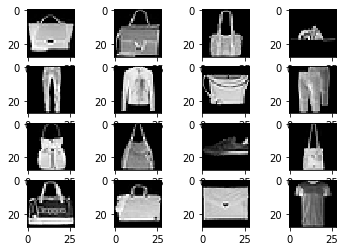

In [5]:
f, axarr = plt.subplots(4,4)
for i in range(4):
    for j in range(4):
        axarr[i, j].imshow(trainxs[np.random.randint(0, len(trainxs))])

In [6]:
trainxs = trainxs.reshape(-1, 784)
devxs = devxs.reshape(-1, 784)
testxs = testxs.reshape(-1, 784)

We can then use .reshape(28, 28) on individual datapoints when we need to display them:

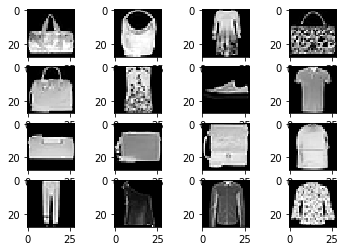

In [7]:
f, axarr = plt.subplots(4,4)
for i in range(4):
    for j in range(4):
        axarr[i, j].imshow(devxs[np.random.randint(0, len(devxs))].reshape(28, 28))

In [24]:
w = np.zeros(784)
s = np.zeros(784)

def f(w, x):
    if np.dot(w, x) >= 0:
        return 1
    else:
        return 0

In [25]:
#Measure Accuracy

def accuracy(w, xs, ys):
    correct = 0
    for i in range(len(xs)):
        if f(w, xs[i]) == ys[i]:
            correct += 1
    return correct/len(xs)*100    

In [26]:
#Efficient Voted Perceptron Algorithm

def voted_perceptron(w, xs, ys, s, epochs, devxs, devys):
    prev_acc = 0
    curr_acc = 0
    counter = 0
    accuracies = []
    
    accuracies_dev = []
    for k in range(epochs):
        for i in range(len(xs)):
            y_hat = f(w, xs[i])
            if y_hat != ys[i]:
                w += (ys[i] - y_hat) * xs[i]
            s += w
        if k:
            prev_acc = curr_acc
        curr_acc = accuracy(s, xs, ys)
        val_acc = accuracy(s, devxs, devys)
        accuracies.append(curr_acc)
        accuracies_dev.append(val_acc)
        print("Epoch", k, ": ", curr_acc)
        if abs(curr_acc - prev_acc) < 0.1:
            counter += 1
            if counter == 5:
                return accuracies, accuracies_dev
        else:
            counter = 0
    return accuracies, accuracies_dev

In [27]:
epochs = 100
train_accuracies, dev_accuracies = voted_perceptron(w, trainxs, trainys, s, epochs, devxs, devys)

Epoch 0 :  96.58333333333333
Epoch 1 :  96.84166666666667
Epoch 2 :  97.0
Epoch 3 :  97.14166666666667
Epoch 4 :  97.13333333333334
Epoch 5 :  97.25
Epoch 6 :  97.25
Epoch 7 :  97.30833333333334
Epoch 8 :  97.29166666666667
Epoch 9 :  97.31666666666666
Epoch 10 :  97.35000000000001


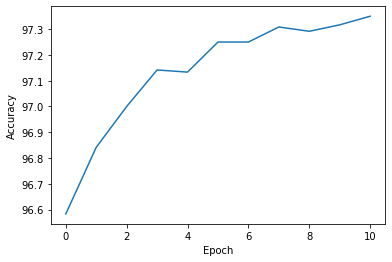

In [28]:
plt.plot(list(range(len(train_accuracies))), train_accuracies)
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()

In [29]:
# plt.axis([0, len(train_accuracies), min(train_accuracies), max(train_accuracies) + 0.1])
# plt.plot(train_accuracies)

In [22]:
# s = np.zeros(784)
# dev_accuracies = voted_perceptron(w, devxs, devys, s, epochs)

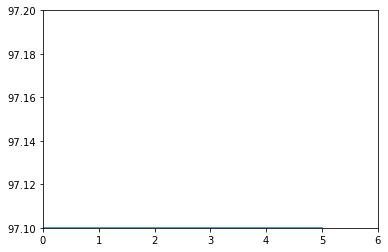

In [23]:
plt.axis([0, len(dev_accuracies), min(dev_accuracies), max(dev_accuracies) + 0.1])
plt.plot(dev_accuracies)

In [17]:
best_epoch = dev_accuracies.index(max(dev_accuracies))
print("Training set: ", train_accuracies[best_epoch])
print("Validation set: ", dev_accuracies[best_epoch])

Training set:  97.0
Validation set:  97.8
